## Linking Mergers Redshift
In this Notebook, we will look at the redshifts of two objects which are very close together any way we can. Will be a limited sample, however.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

from sklearn.cluster import AgglomerativeClustering

import sys

from tqdm import tqdm
tqdm.pandas()

### Getting Data

In [2]:
data_folder = 'E:/GZ-DESI/data/2023-03-15-cats'

In [3]:
df = pd.read_parquet(f'{data_folder}/definitive-merged-interesting-params.parquet', engine = 'pyarrow')

In [4]:
df.category.value_counts()

merger               185278
major_interaction     11594
minor_interaction       267
Name: category, dtype: int64

In [5]:
df_mergers = df.query('category == "merger"')

In [6]:
df_valid = df_mergers[['id_str','ra', 'dec', 'redshift']].dropna()

In [7]:
df_coords = df_valid.assign(coordinates = df_valid.apply(lambda row: SkyCoord(ra = row.ra * u.deg, dec = row.dec * u.deg, frame = 'icrs'), axis = 1))

In [8]:
del df, df_mergers

### Converting Coordiantes

In [9]:
c1 = SkyCoord(ra = df_valid.ra * u.deg, dec = df_valid.dec * u.deg, frame = 'icrs')
c2 = SkyCoord(ra = df_valid.ra * u.deg, dec = df_valid.dec * u.deg, frame = 'icrs')

In [10]:
c1

<SkyCoord (ICRS): (ra, dec) in deg
    [(315.67072916, 10.12636858), (315.87934322, 10.01042352),
     (315.87881118, 10.01111667), ..., (171.05513361, 19.56656874),
     (170.68806769, 19.74760511), (170.78084891, 19.89496207)]>

In [11]:
c2

<SkyCoord (ICRS): (ra, dec) in deg
    [(315.67072916, 10.12636858), (315.87934322, 10.01042352),
     (315.87881118, 10.01111667), ..., (171.05513361, 19.56656874),
     (170.68806769, 19.74760511), (170.78084891, 19.89496207)]>

### Looking for Pairs

In [12]:
df_coords

,id_str,ra,dec,redshift,coordinates
0,390393_113,315.670729,10.126369,0.285089,"<SkyCoord (ICRS): (ra, dec) in deg\n (315.6..."
1,388975_4015,315.879343,10.010424,0.095176,"<SkyCoord (ICRS): (ra, dec) in deg\n (315.8..."
2,388975_4016,315.878811,10.011117,0.308635,"<SkyCoord (ICRS): (ra, dec) in deg\n (315.8..."
4,390397_3464,316.671962,10.263765,0.098369,"<SkyCoord (ICRS): (ra, dec) in deg\n (316.6..."
5,388981_4969,317.310086,10.072413,0.284710,"<SkyCoord (ICRS): (ra, dec) in deg\n (317.3..."
...,...,...,...,...,...
197134,442690_1552,170.788929,19.708979,0.115947,"<SkyCoord (ICRS): (ra, dec) in deg\n (170.7..."
197135,442690_1559,170.789902,19.709089,0.076255,"<SkyCoord (ICRS): (ra, dec) in deg\n (170.7..."
197136,441332_3549,171.055134,19.566569,0.351976,"<SkyCoord (ICRS): (ra, dec) in deg\n (171.0..."
197137,442689_2324,170.688068,19.747605,0.164123,"<SkyCoord (ICRS): (ra, dec) in deg\n (170.6..."


In [13]:
bins_values = np.linspace(0,360,180)

In [14]:
def sort_bin(ra, bins):
    for i in range(1,len(bins)):
        if ra > bins[i-1] and ra <= bins[i]:
            return i-1
    
    print('Binning Failed')
    sys.exit()

In [15]:
df_ra_bin = (
    df_coords
    .assign(ra_bin = df_coords.ra.progress_apply(lambda x: sort_bin(x, bins_values)))
)

100%|██████████| 168847/168847 [00:05<00:00, 30444.14it/s]


In [16]:
dec_bin_values = np.linspace(-90, 90, 90)

In [17]:
df_dec_bin = (
    df_ra_bin
    .assign(dec_bin = df_ra_bin.dec.progress_apply(lambda x: sort_bin(x, dec_bin_values)))
)

100%|██████████| 168847/168847 [00:03<00:00, 48503.47it/s]


In [18]:
potential_list = []
for i in tqdm(range(360)):
    df_ra_tmp = df_dec_bin.query('ra_bin == @i')
    for j in range(180):
        df_tmp = df_ra_tmp.query('dec_bin == @j')
        if len(df_tmp) > 0:
            potential_list.append(list(df_tmp.id_str))

100%|██████████| 360/360 [02:41<00:00,  2.22it/s]


In [19]:
len(potential_list)

6809

In [20]:
inter_list = []
for i in potential_list:
    if len(i) == 1:
        continue
    else:
        inter_list.append(i)

In [22]:
redshift_pair = {}
for i in tqdm(inter_list):
    df_list = pd.DataFrame(i).rename(columns = {0:'id_str'})
    df_merge = df_list.merge(df_coords, on='id_str', how = 'left')
    
    if len(df_merge) == 2:
        sep = float(df_merge.coordinates.iloc[0].separation(df_merge.coordinates.iloc[1]).to(u.arcsec) / u.arcsec)
        if sep <= 10:
            new_id_str = f'{df_merge.id_str.iloc[0]}-{df_merge.id_str.iloc[1]}'
            redshift_pair[new_id_str] = list(df_merge.redshift)        
        
    elif len(df_merge) > 2:
        counter = 0
        while len(df_merge) > 2:
            df_seps = df_merge.assign(seps = df_merge.coordinates.apply(lambda x: float(df_merge.coordinates.iloc[0].separation(x).to(u.arcsec) / u.arcsec)))
            df_rem = df_seps.query('seps > 0')
            df_match = df_rem.query('seps < 10')
            if len(df_match) == 0:
                df_merge = df_rem
            elif len(df_match) == 1:
                orig_id_str = df_merge.id_str.iloc[0]
                match_id_str = df_match.id_str.iloc[0]
            
                new_id_str = f'{orig_id_str}-{match_id_str}'
                redshift_pair[new_id_str] = [df_merge.redshift.iloc[0], df_match.redshift.iloc[0]]
                df_merge = df_seps.query('id_str != @orig_id_str and id_str != @match_id_str')
            elif len(df_match) > 1:
                minimum = df_match.seps.min()
                df_tmp = df_match.query('seps == @minimum')
                
                orig_id_str = df_merge.id_str.iloc[0]
                match_id_str = df_tmp.id_str.iloc[0]
                
                new_id_str = f'{orig_id_str}-{match_id_str}'
                redshift_pair[new_id_str] = [df_merge.redshift.iloc[0], df_tmp.redshift.iloc[0]]
                df_merge = df_seps.query('id_str != @orig_id_str and id_str != @match_id_str')       
            else:
                print('WARNING: Tried to go to an infintie loop.')
                sys.exit()

    else:
        print('Something Failed')
        sys.exit()

100%|██████████| 6734/6734 [1:17:04<00:00,  1.46it/s]


### Plotting Distribution

In [23]:
matched_redshifts = np.asarray(list(redshift_pair.values()))

In [24]:
matched_redshifts.shape

(18544, 2)

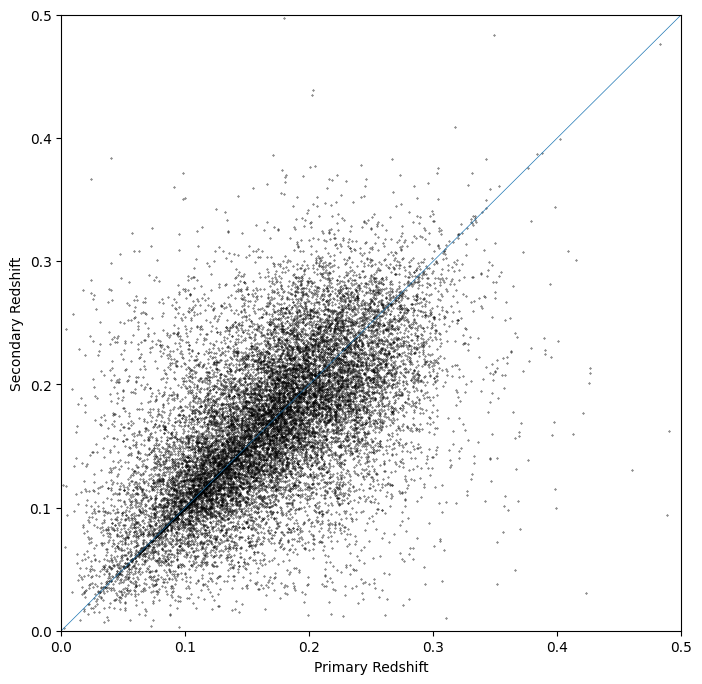

In [25]:
plt.figure(figsize = (8,8))
plt.scatter(matched_redshifts[:,0], matched_redshifts[:,1], color = 'black', s = 0.10)
plt.plot(np.linspace(0,0.5,10), np.linspace(0,0.5,10), linewidth = 0.5)
plt.xlim([0,0.5])
plt.ylim([0,0.5])
plt.xlabel('Primary Redshift')
plt.ylabel('Secondary Redshift')
plt.show()

In [26]:
redshift_frac = matched_redshifts[:,0] / matched_redshifts[:,1]

In [27]:
mask = (redshift_frac > 0.85) & (redshift_frac < 1.15)

In [28]:
len(redshift_frac[mask]) / len(redshift_frac) * 100

43.097497842968075

44.01% of the sources are within a tolerable redshift of each other.

Look at close pairs vs actually interacting throughout all of the sub-samples and investigate correlation/relation.